# Dev Interp - Grokking Modular Addition and Multiplication

# Setup

In [11]:
TRAIN_MODEL = True

In [12]:
# Janky code to do different setup when run in a Colab notebook vs VSCode
import os

DEVELOPMENT_MODE = True
IN_GITHUB = os.getenv("GITHUB_ACTIONS") == "true"
try:
    import google.colab
    IN_COLAB = True
    print("Running as a Colab notebook")

    # PySvelte is an unmaintained visualization library, use it as a backup if circuitsvis isn't working
    # # Install another version of node that makes PySvelte work way faster
    # !curl -fsSL https://deb.nodesource.com/setup_16.x | sudo -E bash -; sudo apt-get install -y nodejs
    # %pip install git+https://github.com/neelnanda-io/PySvelte.git
except:
    IN_COLAB = False
    print("Running as a Jupyter notebook - intended for development only!")
    from IPython import get_ipython

    ipython = get_ipython()
    # Code to automatically update the HookedTransformer code as its edited without restarting the kernel
    ipython.magic("load_ext autoreload")
    ipython.magic("autoreload 2")

if IN_COLAB or IN_GITHUB:
    %pip install transformer_lens
    %pip install circuitsvis

Running as a Jupyter notebook - intended for development only!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/var/folders/85/m4tlmmlj4w58khykxvwgvt980000gn/T/ipykernel_87282/2858945602.py:22: DeprecationWarning:

`magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).

/var/folders/85/m4tlmmlj4w58khykxvwgvt980000gn/T/ipykernel_87282/2858945602.py:23: DeprecationWarning:

`magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).



In [13]:
# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
if IN_COLAB or not DEVELOPMENT_MODE:
    pio.renderers.default = "colab"
else:
    pio.renderers.default = "notebook_connected"
print(f"Using renderer: {pio.renderers.default}")

Using renderer: notebook_connected


In [14]:
pio.templates['plotly'].layout.xaxis.title.font.size = 20
pio.templates['plotly'].layout.yaxis.title.font.size = 20
pio.templates['plotly'].layout.title.font.size = 30

In [15]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from fancy_einsum import einsum
import os
import tqdm.auto as tqdm
import random
from pathlib import Path
import plotly.express as px
from torch.utils.data import DataLoader

from typing import List, Union, Optional
from functools import partial
import copy

import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets
from IPython.display import HTML

In [16]:
import transformer_lens.utils as utils
from transformer_lens import HookedTransformer, HookedTransformerConfig

device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"device: {device}")

device: cpu


Plotting helper functions:

In [17]:
from collections import deque

def rolling_average(values, window_size):
    window = deque(maxlen=window_size)
    averages = []
    
    for value in values:
        window.append(value)
        averages.append(sum(window) / len(window))
    
    return averages

def imshow(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.imshow(utils.to_numpy(tensor), color_continuous_midpoint=0.0, color_continuous_scale="RdBu", labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def line(tensor, renderer=None, xaxis="", yaxis="", **kwargs):
    px.line(utils.to_numpy(tensor), labels={"x":xaxis, "y":yaxis}, **kwargs).show(renderer)

def scatter(x, y, xaxis="", yaxis="", caxis="", renderer=None, **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(y=y, x=x, labels={"x":xaxis, "y":yaxis, "color":caxis}, **kwargs).show(renderer)

# Model Training

In [18]:
DATA_SEED = 598

## Create the dataset
* Define modular addition and modular multiplication datasets
* Combine the two data sets
* We can vary the proportion of addition to multiplication in the training dataset

In [19]:
import pandas as pd
from helpers import get_dataloader

max_nums = 130
mod_value = 113

# The fraction of the data that should be used for training (not all of the rest will be used for testing)
train_frac = 0.5

# The fraction of the training data that should be addition (the rest will be multiplication)
addition_frac = 0.7

def create_dataset(max_nums: int, addition: bool, mod_value: int):
    data = list()
    for a in range(max_nums):
        for b in range(max_nums):
            if addition:
                label = (a + b) % mod_value
            else:
                label = (a * b) % mod_value
            data.append([[a, int(addition), b], label])

    return pd.DataFrame(data, columns=["input", "label"])

addition_df = create_dataset(max_nums, True, mod_value)
multiplication_df = create_dataset(max_nums, False, mod_value)

print(f"Addition dataset size = {len(addition_df)}")
print(f"Multiplication dataset size = {len(multiplication_df)}")

total_train_size = int((len(addition_df) + len(multiplication_df)) * train_frac)

print(f"Total train size = {total_train_size}")
# Calculate the sizes for train datasets based on the desired proportion
add_train_size = int(total_train_size * addition_frac)
multi_train_size = total_train_size - add_train_size

# Determine the size for test datasets (use the remaining data, but ensure equal sizes)
test_size = min(len(addition_df) - add_train_size, len(multiplication_df) - multi_train_size)

# Create train datasets
add_train_df = addition_df.sample(n=add_train_size, random_state=DATA_SEED)
multi_train_df = multiplication_df.sample(n=multi_train_size, random_state=DATA_SEED)

# Create test datasets with equal size
add_test_df = addition_df.drop(add_train_df.index).sample(n=test_size, random_state=DATA_SEED)
multi_test_df = multiplication_df.drop(multi_train_df.index).sample(n=test_size, random_state=DATA_SEED)

# Print sizes for verification
print(f"Addition train size = {len(add_train_df)}")
print(f"Addition test size = {len(add_test_df)}")
print(f"Multiplication train size = {len(multi_train_df)}")
print(f"Multiplication test size = {len(multi_test_df)}")

print(f"Addition: {len(add_train_df)/(len(add_train_df) + len(multi_train_df))*100:0.1f}% \
Multiplication: {len(multi_train_df)/(len(add_train_df) + len(multi_train_df))*100:0.1f}%")

# Combine and shuffle the datasets
train_df = pd.concat([add_train_df, multi_train_df], ignore_index=True).sample(frac=1, random_state=DATA_SEED).reset_index(drop=True)
test_df = pd.concat([add_test_df, multi_test_df], ignore_index=True).sample(frac=1, random_state=DATA_SEED).reset_index(drop=True)

print(f"Combined dataset = {len(train_df) + len(test_df)}")

print(f"Train size = {len(train_df)}")
print(f"Test size = {len(test_df)}")

# Create the dataloaders
train_loader = get_dataloader(train_df, 1024, shuffle=True)
test_loader = get_dataloader(test_df, len(test_df), shuffle=False)

train_data = torch.tensor(train_df['input'].tolist())
train_labels = torch.tensor(train_df['label'].tolist())

test_data = torch.tensor(test_df['input'].tolist())
test_labels = torch.tensor(test_df['label'].tolist())

add_test_data = torch.tensor(add_test_df['input'].tolist())
add_test_labels = torch.tensor(add_test_df['label'].tolist())

multi_test_data = torch.tensor(multi_test_df['input'].tolist())
multi_test_labels = torch.tensor(multi_test_df['label'].tolist())

print(f"train_data.shape = {train_data.shape}")
print(f"train_labels.shape = {train_labels.shape}")
print(f"test_data.shape = {test_data.shape}")
print(f"test_labels.shape = {test_labels.shape}")
print(f"train_data[:10] = {train_data[:10]}")


Addition dataset size = 16900
Multiplication dataset size = 16900
Total train size = 16900
Addition train size = 11830
Addition test size = 5070
Multiplication train size = 5070
Multiplication test size = 5070
Addition: 70.0% Multiplication: 30.0%
Combined dataset = 27040
Train size = 16900
Test size = 10140
train_data.shape = torch.Size([16900, 3])
train_labels.shape = torch.Size([16900])
test_data.shape = torch.Size([10140, 3])
test_labels.shape = torch.Size([10140])
train_data[:10] = tensor([[ 51,   0,  92],
        [ 33,   0, 104],
        [121,   1,  24],
        [114,   0, 120],
        [ 42,   1,  35],
        [129,   1, 115],
        [ 85,   1,   5],
        [108,   1,   3],
        [111,   1, 127],
        [ 14,   1,  32]])


## Define Model

In [20]:

cfg = HookedTransformerConfig(
    n_layers = 1,
    n_heads = 4,
    d_model = 128,
    d_head = 32,
    d_mlp = 512,
    act_fn = "relu",
    normalization_type="LN",
    d_vocab=max_nums+1,
    d_vocab_out=mod_value,
    n_ctx= train_data.shape[1],
    init_weights=True,
    device=device,
    seed = 999,
)

model = HookedTransformer(cfg)

Disable the biases, as we don't need them for this task and it makes things easier to interpret.

In [21]:
for name, param in model.named_parameters():
    if "b_" in name:
        param.requires_grad = False


## Define Optimizer + Loss

In [22]:
# Optimizer config
lr = 1e-3
wd = 1.
betas = (0.90, 0.98)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd, betas=betas)

In [23]:
from helpers import loss_fn

train_logits = model(train_data)
train_loss = loss_fn(train_logits, train_labels)
print(f"train_loss = {train_loss}")
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(f"test_loss = {test_loss}")

train_loss = 5.046054775218921
test_loss = 5.063647319925165


## Actually Train

In [24]:
num_epochs = 6000
checkpoint_every = 50
train_losses = []
test_losses = []
add_test_losses = []
multi_test_losses = []
model_checkpoints = []
checkpoint_epochs = []
if TRAIN_MODEL:
    for epoch in tqdm.tqdm(range(num_epochs)):
        model.train()
        train_logits = model(train_data)
        train_loss = loss_fn(train_logits, train_labels)
        train_loss.backward()
        train_losses.append(train_loss.item())
        optimizer.step()
        optimizer.zero_grad()

        model.eval()
        with torch.inference_mode():
            # General test loss
            test_logits = model(test_data)
            test_loss = loss_fn(test_logits, test_labels)
            test_losses.append(test_loss.item())

            if (epoch+1) % 10 == 0:
                # Addition test loss
                add_test_logits = model(add_test_data)
                add_test_loss = loss_fn(add_test_logits, add_test_labels)
                add_test_losses.append(add_test_loss.item())

                # Multiplication test loss
                multi_test_logits = model(multi_test_data)
                multi_test_loss = loss_fn(multi_test_logits, multi_test_labels)
                multi_test_losses.append(multi_test_loss.item())

        if ((epoch+1)%checkpoint_every)==0:
            checkpoint_epochs.append(epoch)
            model_checkpoints.append(copy.deepcopy(model.state_dict()))
            print(f"Epoch {epoch} Train Loss {train_loss.item()} Test Loss {test_loss.item()} Add Test Loss {add_test_loss.item()} Multi Test Loss {multi_test_loss.item()}")

  0%|          | 0/6000 [00:00<?, ?it/s]

Epoch 49 Train Loss 4.277777464780242 Test Loss 4.992589516243763 Add Test Loss 4.968104757012041 Multi Test Loss 5.017074275475484
Epoch 99 Train Loss 2.3323388830118086 Test Loss 4.679703669886263 Add Test Loss 4.067289081225264 Multi Test Loss 5.292118258547264
Epoch 149 Train Loss 0.9100322994270037 Test Loss 4.471846614150029 Add Test Loss 3.1747122831673082 Multi Test Loss 5.76898094513275
Epoch 199 Train Loss 0.31112498532347793 Test Loss 4.528157821610401 Add Test Loss 2.8162470771030015 Multi Test Loss 6.2400685661178
Epoch 249 Train Loss 0.1201765819296633 Test Loss 4.5924579228335425 Add Test Loss 2.5772731817408303 Multi Test Loss 6.6076426639262555
Epoch 299 Train Loss 0.05973342000406222 Test Loss 4.6022210732388285 Add Test Loss 2.3698936703489712 Multi Test Loss 6.834548476128684
Epoch 349 Train Loss 0.034447587102208806 Test Loss 4.585877719212495 Add Test Loss 2.1765268212547872 Multi Test Loss 6.995228617170203
Epoch 399 Train Loss 0.020806219183235268 Test Loss 4.56

In [379]:
PTH_LOCATION = "../saves/check_point_50/grokking_add_multi_0.7.pth"
if TRAIN_MODEL:
    # Create the directory if it does not exist
    os.makedirs(Path(PTH_LOCATION).parent, exist_ok=True)
    
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")
    torch.save(
        {
            "model":model.state_dict(),
            "config": model.cfg,
            "checkpoints": model_checkpoints,
            "checkpoint_epochs": checkpoint_epochs,
            "test_losses": test_losses,
            "train_losses": train_losses,
            "add_test_losses": add_test_losses,
            "multi_test_losses": multi_test_losses,
            "max_nums": max_nums,
            "mod_value": mod_value,
            "train_frac": train_frac,
            "addition_frac": addition_frac,
            "learning_rate": lr,
            "weight_decay": wd,
            "betas": betas,
            "train_data": train_data,
            "train_labels": train_labels,
            "test_data": test_data,
            "test_labels": test_labels,
        },
        PTH_LOCATION)

len(train_losses) = 6000 len(test_losses) = 6000 len(model_checkpoints) = 120


In [311]:
LOAD_LOCATION = "../saves/grokking_add_multi_0.5.pth"
if not TRAIN_MODEL:
    cached_data = torch.load(LOAD_LOCATION, weights_only=False)
    model.load_state_dict(cached_data['model'])
    model_checkpoints = cached_data["checkpoints"]
    checkpoint_epochs = cached_data["checkpoint_epochs"]
    test_losses = cached_data['test_losses']
    train_losses = cached_data['train_losses']
    add_test_losses = cached_data['add_test_losses']
    multi_test_losses = cached_data['multi_test_losses']
    max_nums = cached_data['max_nums']
    mod_value = cached_data['mod_value']
    train_frac = cached_data['train_frac']
    addition_frac = cached_data['addition_frac']
    print(f"train_frac = {train_frac} addition_frac = {addition_frac}")
    print(f"len(train_losses) = {len(train_losses)} len(test_losses) = {len(test_losses)} len(model_checkpoints) = {len(model_checkpoints)}")

train_frac = 0.5 addition_frac = 0.5
len(train_losses) = 4000 len(test_losses) = 4000 len(model_checkpoints) = 40


In [380]:
test_logits = model(test_data)
test_loss = loss_fn(test_logits, test_labels)
print(f"test_loss = {test_loss}")

test_loss = 0.10750396571662794


## Show Model Training Statistics, Check that it groks!

In [381]:
from neel_plotly.plot import line
step = 10
average_window = 200
train_losses_avg = rolling_average(train_losses, average_window)
test_losses_avg = rolling_average(test_losses, average_window)
add_test_losses_avg = rolling_average(add_test_losses, average_window//10)
multi_test_losses_avg = rolling_average(multi_test_losses, average_window//10)

line([train_losses[::step], test_losses[::step], add_test_losses, multi_test_losses], x=np.arange(0, len(train_losses_avg), step), xaxis="Epoch", yaxis="Loss", log_y=False, title=f"Training Curve for Modular Arithmetic - {addition_frac*100:.0f}% Addition", line_labels=['train loss', 'test loss', 'add loss', 'multi loss'], toggle_x=True, toggle_y=True)
line([train_losses_avg[::step], test_losses_avg[::step], add_test_losses_avg, multi_test_losses_avg], x=np.arange(0, len(train_losses_avg), step), xaxis="Epoch", yaxis="Rolling Avg Loss", log_y=False, title=f"Training Curve for Modular Arithmetic - {addition_frac*100:.0f}% Addition", line_labels=['train', 'test', 'add loss', 'multi loss'], toggle_x=True, toggle_y=True)

### Estiamtating Local Learning Coefficient (RLCT)

len(model_checkpoints) = 120
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 1000/1000 [00:24<00:00, 40.18it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 1000/1000 [00:24<00:00, 41.08it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 1000/1000 [00:24<00:00, 40.37it/s]


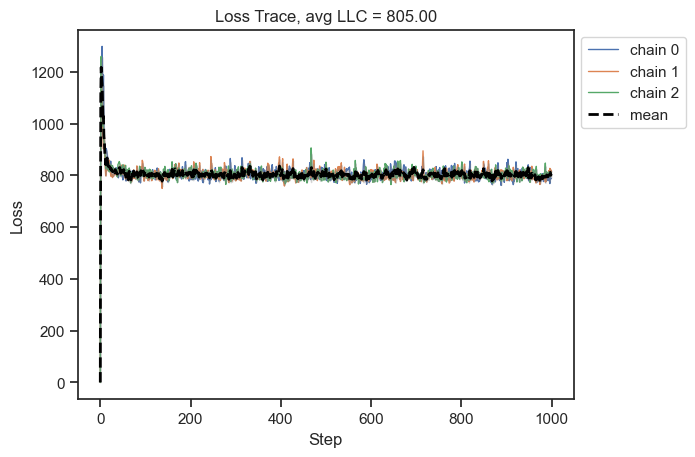

<Figure size 1200x900 with 0 Axes>

In [387]:
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

print(f"len(model_checkpoints) = {len(model_checkpoints)}")

model.load_state_dict(model_checkpoints[10])

results = estimate_learning_coeff_with_summary(
                model,
                loader=train_loader,
                evaluate=evaluate,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=5e-4, localization=100.0),
                num_chains=3,          # How many independent chains to run
                num_draws=1000,            # How many samples to draw per chain
                num_burnin_steps=0,    # How many samples to discard at the beginning of each chain
                num_steps_bw_draws=1,   # How many steps to take between each sample
                device=device,
                online=True,
            )

plot_trace(
    results["llc/trace"],
    "Loss",
    x_axis="Step",
    title=f"Loss Trace, avg LLC = {sum(results['llc/means']) / len(results['llc/means']):.2f}",
    plot_mean=False,
    plot_std=False,
    fig_size=(12, 9),
    true_lc=None,
)

In [314]:
from devinterp.slt.sampler import estimate_learning_coeff_with_summary, estimate_learning_coeff, SGLD
from devinterp.utils import plot_trace

def evaluate(model, data):
    inputs, outputs = data

    return loss_fn(model(inputs), outputs), {
        "logits": model(inputs)
    }

llc_estimates = []

for saved_model in tqdm.tqdm(model_checkpoints):
    model.load_state_dict(saved_model)
    result = estimate_learning_coeff(
                model,
                loader=train_loader,
                evaluate=evaluate,
                sampling_method=SGLD,
                optimizer_kwargs=dict(lr=5e-4, localization=100.0),
                num_chains=15,           # How many independent chains to run
                num_draws=5,            # How many samples to draw per chain
                num_burnin_steps=20,    # How many samples to discard at the beginning of each chain
                num_steps_bw_draws=1,   # How many steps to take between each sample
                device=device,
                #online=True,
            )
    llc_estimates.append(result)
    print(f"result = {result}")

# Graph the LLC estimates
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)

  0%|          | 0/40 [00:00<?, ?it/s]

/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/slt/sampler.py:54: UserWarning:

nbeta not set - using default nbeta.



Moving model to device:  cpu


/Users/james/dev/ArithmeticTransformer/.venv/lib/python3.12/site-packages/devinterp/backends/default/slt/sampler.py:234: UserWarning:

If you're setting a nbeta in optimizer_kwargs, please also make sure to set it in the callbacks.



Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 37.55it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 40.48it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.85it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 37.66it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 37.65it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 28.73it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 31.57it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 35.17it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 38.46it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 36.96it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.13it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 37.33it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 37.87it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 37.84it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 37.41it/s]


result = 378.1568603515625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 37.71it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 35.94it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 38.77it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 38.38it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 27.80it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.85it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 35.55it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 39.30it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 37.53it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 39.89it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 40.45it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 39.57it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 38.70it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 38.48it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 36.16it/s]


result = 632.3897094726562
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 40.30it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 39.41it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 39.55it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 39.74it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 31.34it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 36.63it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 38.98it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 38.90it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 39.08it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 38.06it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 37.95it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 37.72it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 38.47it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 38.26it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 38.82it/s]


result = 679.1881103515625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 37.94it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 39.58it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 37.06it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 38.17it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 31.01it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 39.05it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 39.85it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 39.46it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 39.62it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 38.10it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 38.99it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 38.51it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 38.62it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 41.02it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.99it/s]


result = 687.9039306640625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 38.62it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 37.71it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 38.10it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 29.98it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 38.78it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 35.89it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 38.85it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 35.79it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 38.60it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 38.39it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 39.46it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 35.24it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 37.68it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 37.73it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 39.33it/s]


result = 684.4478759765625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 38.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 37.26it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.58it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 37.96it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 37.78it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 37.32it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 38.66it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 36.05it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.65it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 35.27it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 38.81it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 36.98it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 35.45it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 37.02it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 38.33it/s]


result = 697.6310424804688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 35.97it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 36.35it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.40it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 35.95it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.44it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 37.21it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.57it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 36.76it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 36.07it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.46it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 36.64it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 36.15it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.64it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 32.44it/s]


result = 696.1800537109375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 35.85it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.40it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 35.48it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 34.66it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.62it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 35.24it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.99it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.12it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.33it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.81it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.70it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 35.25it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.56it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.36it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 32.23it/s]


result = 693.1669311523438
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 36.79it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 28.41it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 35.69it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 34.58it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.37it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 35.64it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 35.46it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.85it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 35.13it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.33it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.28it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 35.56it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.31it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.31it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.60it/s]


result = 689.7379760742188
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 26.77it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.84it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.42it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 35.05it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.88it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.40it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.91it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.82it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 35.40it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.33it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 32.48it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.24it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 35.21it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.30it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.16it/s]


result = 680.7289428710938
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 27.06it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 35.17it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.06it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.91it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.10it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 34.76it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.31it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 35.11it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.97it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.93it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.89it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 32.59it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 31.90it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.09it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.01it/s]


result = 683.0399780273438
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 27.99it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 32.20it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.90it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 34.56it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.80it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 34.16it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.32it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 36.21it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 35.08it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.84it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 36.42it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 32.18it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 35.53it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.60it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.41it/s]


result = 613.356689453125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 35.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 32.25it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.78it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 35.75it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 35.83it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 35.03it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.67it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 35.02it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.74it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 33.73it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 28.63it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:01<00:00, 24.92it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 29.04it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:01<00:00, 20.68it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 27.08it/s]


result = 691.0194091796875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 30.52it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.91it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 28.45it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.52it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 31.90it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 32.35it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.57it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.97it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 31.16it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 31.26it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 32.42it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 28.29it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 30.40it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.82it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.91it/s]


result = 577.3773193359375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 29.52it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 31.39it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.44it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 32.04it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.14it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.87it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.06it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 25.74it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 27.63it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.35it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 32.94it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.30it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 33.55it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 31.06it/s]


result = 693.2532348632812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.21it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.43it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.88it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.28it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 31.90it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.77it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.08it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.13it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.48it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 32.11it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.71it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.44it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.87it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 33.62it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 25.99it/s]


result = 480.97296142578125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.33it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 31.69it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.88it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.43it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.48it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.72it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.57it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.50it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.27it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 33.45it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 31.80it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.58it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.63it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.46it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 27.36it/s]


result = 699.0858154296875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 31.79it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.44it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.19it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.80it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 35.06it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.50it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.35it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.86it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.94it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 33.28it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 30.77it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.26it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.71it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 27.32it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.19it/s]


result = 712.9981079101562
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.13it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 32.21it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 32.88it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 34.93it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.19it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.14it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.41it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.85it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.89it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.69it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.55it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.43it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.86it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 27.41it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 31.57it/s]


result = 717.8961791992188
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 35.07it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 32.40it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.86it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 32.93it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 30.57it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.71it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.07it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.55it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.53it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 31.37it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.66it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.45it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 26.18it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.51it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.31it/s]


result = 723.312744140625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.66it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 31.89it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.49it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.93it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 31.29it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 32.34it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.38it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.15it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.80it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.74it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 32.45it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 25.79it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 32.43it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 31.71it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.98it/s]


result = 732.8577880859375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 30.99it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 31.32it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.33it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.90it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.22it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.50it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 31.02it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 31.93it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 31.10it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.69it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 31.04it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 25.18it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 31.02it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.09it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.69it/s]


result = 740.9212646484375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 30.76it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.99it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.46it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.95it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.07it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.77it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 31.11it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.84it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.38it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.57it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:01<00:00, 24.65it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 30.53it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 31.12it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 28.75it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.13it/s]


result = 756.6350708007812
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 30.31it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.86it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 28.59it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.44it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.33it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.43it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 30.52it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.67it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 30.59it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 30.59it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:01<00:00, 24.54it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 31.15it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 27.68it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.49it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.89it/s]


result = 764.4609985351562
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 29.32it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 27.41it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 30.22it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 29.36it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 29.47it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.19it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 27.85it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.92it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 30.33it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:01<00:00, 24.27it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.59it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 26.13it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 29.83it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.17it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.68it/s]


result = 770.5904541015625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 27.99it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.01it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 29.79it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 29.58it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 27.13it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 26.95it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.74it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.83it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:01<00:00, 24.63it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.23it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.20it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:01<00:00, 24.31it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:01<00:00, 23.65it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:01<00:00, 23.30it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:01<00:00, 24.13it/s]


result = 779.5470581054688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 26.72it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 27.55it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 28.64it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 28.02it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.30it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 28.67it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 27.14it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.09it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:01<00:00, 23.66it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.29it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 27.20it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 29.61it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 28.55it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 29.00it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 25.28it/s]


result = 772.6959228515625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 28.26it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 27.63it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 28.70it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 26.23it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 27.83it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 29.15it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 29.70it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:01<00:00, 22.06it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 28.65it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 25.89it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 27.75it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 25.10it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 27.64it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 28.43it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.15it/s]


result = 777.8515014648438
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 25.29it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 28.12it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 27.39it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:01<00:00, 24.00it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:01<00:00, 24.78it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 26.15it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:01<00:00, 20.10it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 28.39it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 29.81it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 28.80it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 26.91it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 30.19it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 29.76it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.70it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 28.62it/s]


result = 776.8673706054688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 30.94it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 28.17it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 32.23it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 32.00it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 30.89it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.02it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:01<00:00, 22.38it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.62it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.60it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 31.02it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 29.92it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 32.05it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 31.67it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 31.63it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 32.42it/s]


result = 784.8438720703125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 33.33it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.75it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.34it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.04it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 31.28it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 27.40it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.94it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.97it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.93it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 31.11it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.39it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.44it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.79it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.65it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.86it/s]


result = 786.1798095703125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 36.69it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.78it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 34.82it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.68it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 34.03it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 27.33it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.89it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 34.98it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.28it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 35.30it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.99it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 35.40it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 33.29it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.11it/s]


result = 782.5722045898438
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 35.18it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 34.23it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 32.08it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 35.37it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 28.15it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 34.85it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 35.20it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.95it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 35.71it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.76it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 35.44it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 34.88it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 32.90it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.26it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 35.66it/s]


result = 779.452392578125
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.76it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 29.13it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.62it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 31.15it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 27.02it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.45it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.04it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.98it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.60it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 31.92it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.70it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 31.96it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 32.50it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 35.02it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.22it/s]


result = 774.8599853515625
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.68it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.67it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 31.48it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 26.90it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.45it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 30.43it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 31.99it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.31it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 34.63it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 31.24it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 31.60it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 32.93it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.13it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 33.05it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 30.29it/s]


result = 772.6307373046875
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.63it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 32.60it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 32.64it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 25.97it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.09it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.59it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.99it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.89it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 31.03it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 33.77it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.25it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.95it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.29it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.90it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.46it/s]


result = 774.5713500976562
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.56it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 33.16it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:01<00:00, 24.45it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.99it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 32.81it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.65it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 33.69it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.28it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.34it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 34.12it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 33.31it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 31.51it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.00it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 34.17it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 34.24it/s]


result = 778.2013549804688
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 33.51it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 30.00it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 27.60it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.92it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.69it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 31.20it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.78it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 32.18it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.21it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 33.53it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 31.08it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.81it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 34.02it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.70it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 29.78it/s]


result = 782.1234130859375
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 32.13it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 27.80it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.19it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 33.60it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 30.97it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 32.64it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 34.37it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 33.46it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 33.68it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 31.63it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.06it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.32it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 33.55it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 30.86it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 33.49it/s]


result = 785.4961547851562
Moving model to device:  cpu
Moving model to device:  cpu
Moving model to device:  cpu


Chain 0: 100%|██████████| 25/25 [00:00<00:00, 34.00it/s]


Moving model to device:  cpu


Chain 1: 100%|██████████| 25/25 [00:00<00:00, 27.36it/s]


Moving model to device:  cpu


Chain 2: 100%|██████████| 25/25 [00:00<00:00, 33.83it/s]


Moving model to device:  cpu


Chain 3: 100%|██████████| 25/25 [00:00<00:00, 30.27it/s]


Moving model to device:  cpu


Chain 4: 100%|██████████| 25/25 [00:00<00:00, 33.57it/s]


Moving model to device:  cpu


Chain 5: 100%|██████████| 25/25 [00:00<00:00, 33.11it/s]


Moving model to device:  cpu


Chain 6: 100%|██████████| 25/25 [00:00<00:00, 32.72it/s]


Moving model to device:  cpu


Chain 7: 100%|██████████| 25/25 [00:00<00:00, 30.72it/s]


Moving model to device:  cpu


Chain 8: 100%|██████████| 25/25 [00:00<00:00, 32.60it/s]


Moving model to device:  cpu


Chain 9: 100%|██████████| 25/25 [00:00<00:00, 33.21it/s]


Moving model to device:  cpu


Chain 10: 100%|██████████| 25/25 [00:00<00:00, 34.01it/s]


Moving model to device:  cpu


Chain 11: 100%|██████████| 25/25 [00:00<00:00, 33.09it/s]


Moving model to device:  cpu


Chain 12: 100%|██████████| 25/25 [00:00<00:00, 30.87it/s]


Moving model to device:  cpu


Chain 13: 100%|██████████| 25/25 [00:00<00:00, 32.82it/s]


Moving model to device:  cpu


Chain 14: 100%|██████████| 25/25 [00:00<00:00, 32.35it/s]

result = 791.514404296875


In [315]:
line(llc_estimates, xaxis="Epoch", yaxis="LLC", title="Learning Coefficient Estimates", log_y=False, toggle_x=True, toggle_y=True)

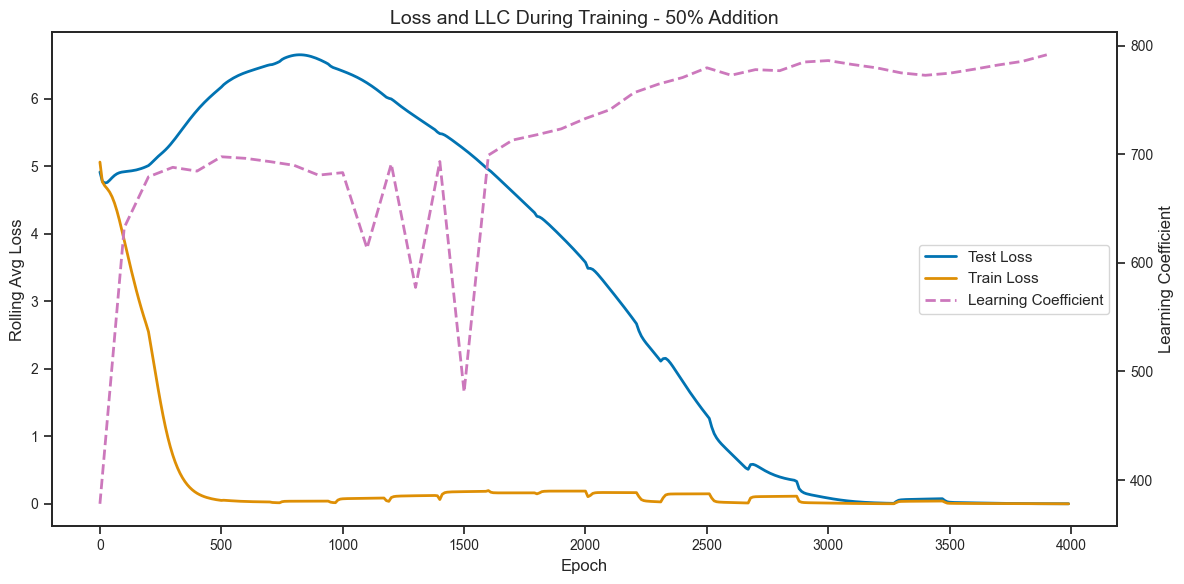

In [319]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have your data prepared as before
epochs = np.arange(0, 4000, 10)
lc_epochs = np.arange(0, 4000, 100)

# Set up the plot
plt.figure(figsize=(12, 6))
sns.set_style("ticks")

# Create the main axis
ax1 = plt.gca()

# Plot loss curves
ax1.plot(epochs, test_losses_avg[::10], color=colors[0], label='Test Loss', linewidth=2)
ax1.plot(epochs, train_losses_avg[::10], color=colors[1], label='Train Loss', linewidth=2)
#ax1.plot(epochs, add_test_losses_avg, color=colors[2], label='Addition Only Test Loss', linewidth=2)
#ax1.plot(epochs, multi_test_losses_avg, color=colors[3], label='Multiplication Only Test Loss', linewidth=2)

# Set up the second y-axis for learning coefficient
ax2 = ax1.twinx()
ax2.plot(lc_epochs, llc_estimates[:4000], color=colors[4], linestyle='--', label='Learning Coefficient', linewidth=2)

# Customize the plot
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Rolling Avg Loss', fontsize=12)
ax2.set_ylabel('Learning Coefficient', fontsize=12)
plt.title(f"Loss and LLC During Training - {addition_frac*100:.0f}% Addition", fontsize=14)

# Adjust tick parameters
ax1.tick_params(axis='both', which='major', labelsize=10)
ax2.tick_params(axis='y', which='major', labelsize=10)

# Create a combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right') # bbox_to_anchor=(1.1, 1), fontsize=10)

plt.tight_layout()
plt.show()